0 [25.939, 0.3, 'Model A']
1 [29.593, 0.5, 'Model B']
2 [33.125, 0.6, 'Model C']
3 [29.593, 0.7, 'Model D']
4 [71.215, 0.473, 'Model E']
5 [27.062, 0.36, 'Model F']
6 [38.449, 0.342, 'Model G']
7 [35.807, 0.609, 'Model H']
8 [17.831, 0.36, 'Model I']
0
10
20
30
40
50
60
70
80


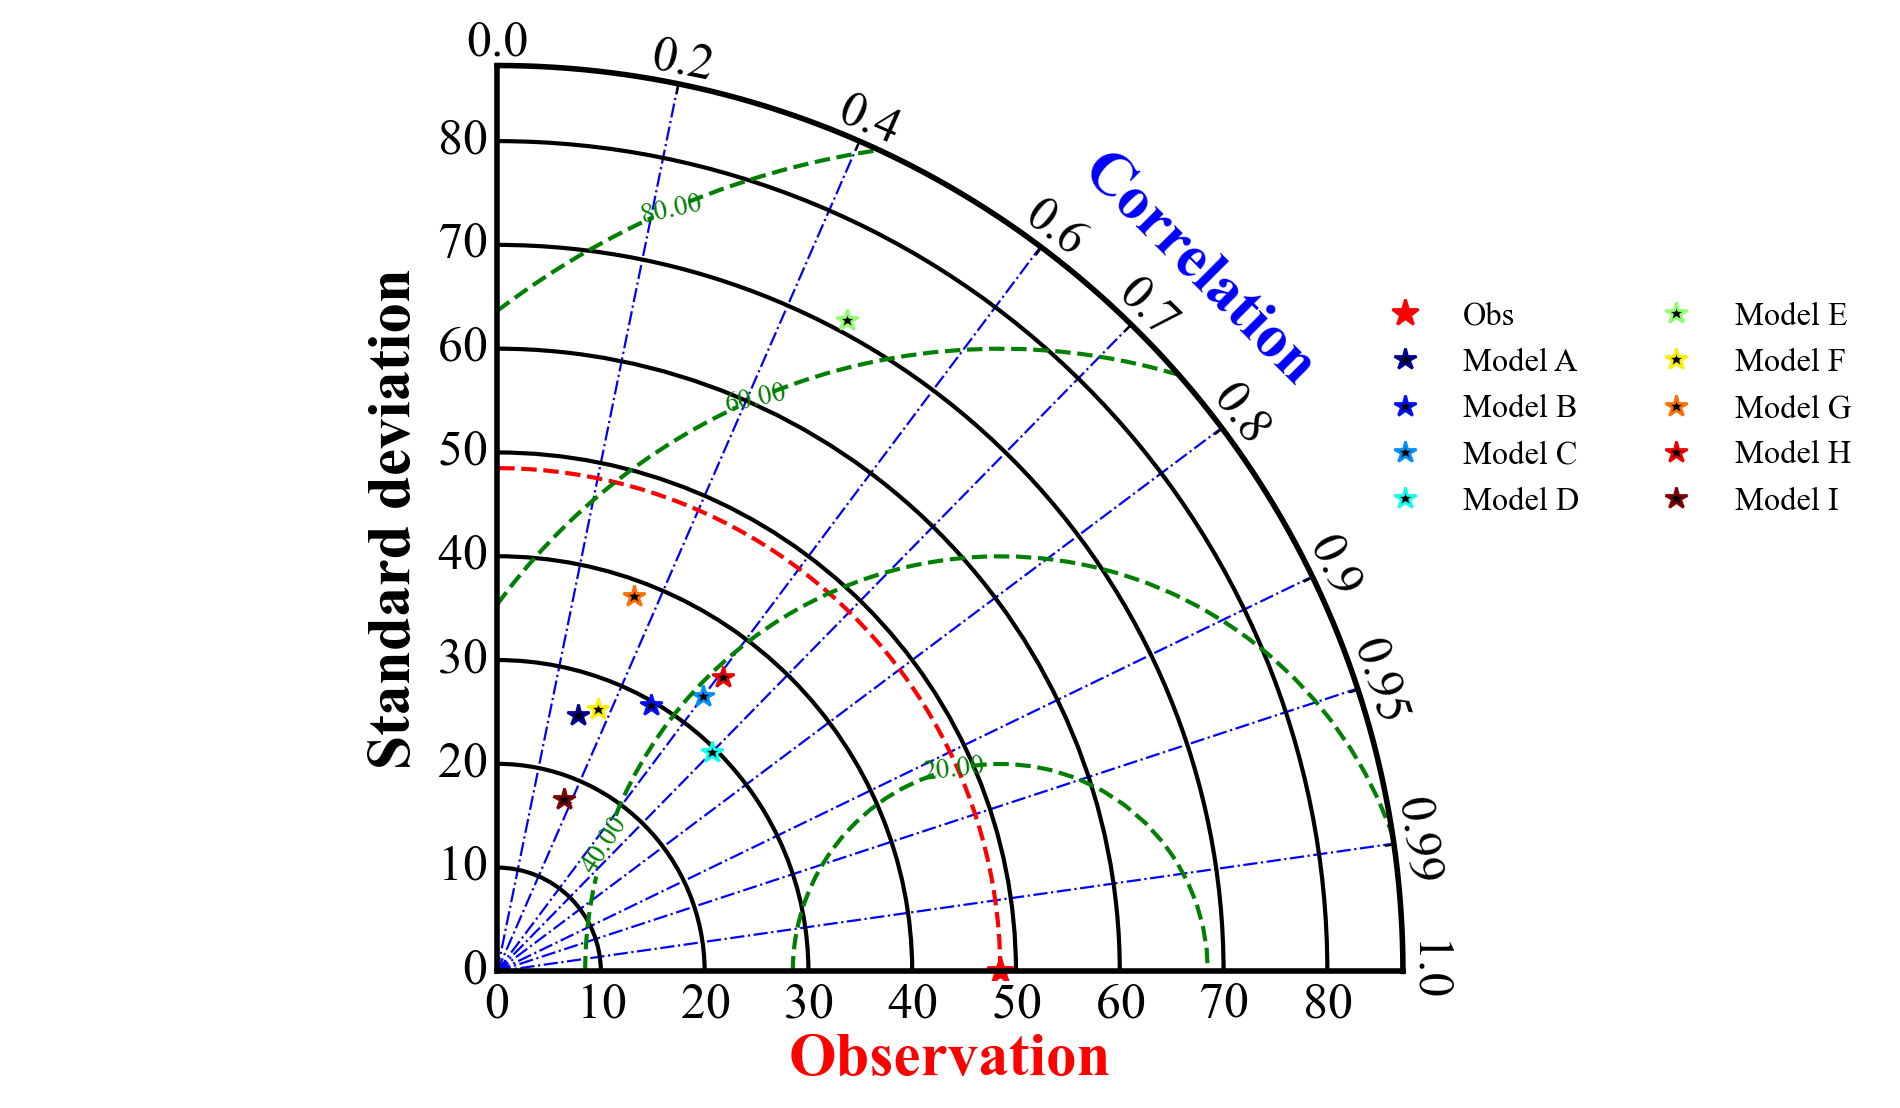

In [2]:
# -*- coding: utf-8 -*-
"""
Created on %(date)s

@author: jianpu

@email : xianpuji@hhu.edu.cn

# ================================================================================================
# Author: %(Jianpu)s | Affiliation: Hohai
# Email : %(email)s
# Last modified:  'date': time.strftime("%Y-%m-%d %H:%M"),
# Filename: 
# =================================================================================================

"""






import matplotlib.ticker as ticker
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
import pandas as pd
from matplotlib import gridspec
from matplotlib.colors import ListedColormap 
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import os
import glob
from datetime import datetime, timedelta
import cmaps
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cftime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as patches






plt.rcParams['font.family'] = 'Times New Roman'   
plt.rcParams['font.size'] = 14

def save_figure(fig,filename='meridional_mean'):
    
    fnFIG = os.path.splitext(os.path.basename(__file__))[0]
    
    outfolder = fnFIG

    if not os.path.exists(outfolder):
        os.makedirs(outfolder)
        print(f'{outfolder} has been created')
    else:
        print(f'{outfolder} already exists')
    
    outpath = os.path.join(outfolder, filename)
    fig.savefig(outpath, dpi=300, bbox_inches='tight')



class TaylorDiagram(object):
    """
    Taylor diagram.

    Plot model standard deviation and correlation to reference (data)
    sample in a single-quadrant polar plot, with r=stddev and
    theta=arccos(correlation).
    """

    def __init__(self, refstd,
                  fig=None, rect=111, label='_', srange=(0, 1.5), extend=False,
                  xlabel='Obs'):
        """
        Set up Taylor diagram axes, i.e. single quadrant polar
        plot, using `mpl_toolkits.axisartist.floating_axes`.

        Parameters:

        * refstd: reference standard deviation to be compared to
        * fig: input Figure or None
        * rect: subplot definition
        * label: reference label
        * srange: stddev axis extension, in units of *refstd*
        * extend: extend diagram to negative correlations
        """

        from matplotlib.projections import PolarAxes
        import mpl_toolkits.axisartist.floating_axes as FA
        import mpl_toolkits.axisartist.grid_finder as GF

        self.refstd = refstd            # Reference standard deviation

        tr = PolarAxes.PolarTransform()

        # Correlation labels
        rlocs = np.array([0, 0.2, 0.4, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1])
        if extend:
            # Diagram extended to negative correlations
            self.tmax = np.pi
            rlocs = np.concatenate((-rlocs[:0:-1], rlocs))
        else:
            # Diagram limited to positive correlations
            self.tmax = np.pi/2
        tlocs = np.arccos(rlocs)        # Conversion to polar angles
        gl1 = GF.FixedLocator(tlocs)    # Positions
        tf1 = GF.DictFormatter(dict(zip(tlocs, map(str, rlocs))))

        # Standard deviation axis extent (in units of reference stddev)
        self.smin = srange[0] * self.refstd
        self.smax = srange[1] * self.refstd

        ghelper = FA.GridHelperCurveLinear(
            tr,
            extremes=(0, self.tmax, self.smin, self.smax),
            grid_locator1=gl1, tick_formatter1=tf1)

        if fig is None:
            fig = plt.figure()

        ax = FA.FloatingSubplot(fig, rect, grid_helper=ghelper)
        fig.add_subplot(ax)
        
        
        # Adjust axes
        ax.axis["right"].major_ticklabels.set_fontsize(18)
        ax.axis["left"].major_ticklabels.set_fontsize(18)
        ax.axis["top"].major_ticklabels.set_fontsize(18)
        ax.axis["top"].set_axis_direction("bottom")   # "Angle axis"
        ax.axis["top"].toggle(ticklabels=True, label=True)
        ax.axis["right"].toggle(ticklabels=True, label=True)
        ax.axis["top"].major_ticklabels.set_axis_direction("top")
        ax.axis["top"].label.set_axis_direction("top")
        ax.axis["left"].set_axis_direction("bottom")  # "X axis"
        
        ax.axis["right"].label.set_fontsize(22)
        ax.axis["right"].label.set_weight('bold')
        ax.axis["left"].label.set_fontsize(22)
        ax.axis["left"].label.set_weight('bold')
        ax.axis["top"].label.set_fontsize(22)
        ax.axis["top"].label.set_weight('bold')
        ax.axis["left"].label.set_color('red') 
        ax.axis["right"].label.set_color('k') 
        ax.axis["top"].label.set_color('b') 
        
        ax.axis["left"].label.set_text("Observation")
        ax.axis["right"].label.set_text("Standard deviation")
        ax.axis["top"].label.set_text("Correlation")
        
        ax.axis["left"].line.set_linewidth(2)
        ax.axis["top"].line.set_linewidth(2)
        ax.axis["right"].line.set_linewidth(2)
        
        ax.axis["right"].set_axis_direction("top")    # "Y-axis"
        ax.axis["right"].toggle(ticklabels=True)
        ax.axis["right"].major_ticklabels.set_axis_direction(
            "bottom" if extend else "left")

        if self.smin:
            ax.axis["bottom"].toggle(ticklabels=False, label=False)
        else:
            ax.axis["bottom"].set_visible(False)          # Unused

        self._ax = ax                   # Graphical axes
        self.ax = ax.get_aux_axes(tr)   # Polar coordinates

        # Add reference point and stddev contour
        l, = self.ax.plot([0], self.refstd, 'r*',
                          ls='', ms=10, label=label)
        t = np.linspace(0, self.tmax)
        r = np.zeros_like(t) + self.refstd
        self.ax.plot(t, r, 'r--', label='_')

        # Collect sample points for latter use (e.g. legend)
        self.samplePoints = [l]
        
    def draw_outer_border(self, ax):
        """
        Draw an outer border around the polar plot.
        """
        # Create a circle patch
        outer_border = patches.Circle(
            (0, 0), self.smax,
            transform=ax.transData._b,  # Use the polar transformation
            color='black', linewidth=2, fill=False, linestyle='--'
        )
        
        # Add the patch to the plot
        ax.add_patch(outer_border)
        
    def add_sample(self, stddev, corrcoef, *args, **kwargs):
        """
        Add sample (*stddev*, *corrcoeff*) to the Taylor
        diagram. *args* and *kwargs* are directly propagated to the
        `Figure.plot` command.
        """

        l, = self.ax.plot(np.arccos(corrcoef), stddev,
                          *args, **kwargs)  # (theta, radius)
        self.samplePoints.append(l)
        
        return l

    def add_grid(self,stdcolor,corrcolor, *args, **kwargs):
        grid = self._ax.grid(color=corrcolor,*args, **kwargs)
        """Add a grid."""
        rlocs = np.arange(0,90,10)  # 生成多个标准差值，可以根据需要进行更改
        for r in rlocs:
            print(r)
            circle = plt.Circle((0, 0), r, transform=self._ax.transData._b, color=stdcolor,
                                fill=False, linestyle='-',linewidth=1.5,zorder=2)
            self._ax.add_patch(circle)
        
        
        return grid

    def add_contours(self, levels=5, **kwargs):
        """
        Add constant centered RMS difference contours, defined by *levels*.
        """

        rs, ts = np.meshgrid(np.linspace(self.smin, self.smax),
                              np.linspace(0, self.tmax))
        # Compute centered RMS difference
        rms = np.sqrt(self.refstd**2 + rs**2 - 2*self.refstd*rs*np.cos(ts))

        contours = self.ax.contour(ts, rs, rms, levels,colors='green', linestyles='--', **kwargs)

        return contours




    
    
def test1():
    """Display a Taylor diagram in a separate axis."""
    # Reference std
    stdref = 48.491

    # Samples std,rho,name
    samples = [[25.939, 0.3, "Model A"],
               [29.593, 0.5, "Model B"],
               [33.125, 0.6, "Model C"],
               [29.593, 0.7, "Model D"],
               [71.215, 0.473, "Model E"],
               [27.062, 0.360, "Model F"],
               [38.449, 0.342, "Model G"],
               [35.807, 0.609, "Model H"],
               [17.831, 0.360, "Model I"]]

    
    refstd = stdref
    
    fig = plt.figure(figsize=(12, 6),dpi=200)
    # Taylor diagram
    dia = TaylorDiagram(refstd, fig=fig, rect=111, label="Obs",
                        srange=(0., 1.8))
    
    colors = cmaps.matlab_jet(np.linspace(0, 1, len(samples)))
    

    # Add the models to Taylor diagram
    for i, model in enumerate(samples):
        print(i,model)

        marker_color = colors[i]
        label_color = 'black'           # Set legend label color to black
        dia.add_sample(samples[i][0], samples[i][1],
                        marker='*',
                        ms=8, ls='',
                        mec=marker_color,
                        label=f"{samples[i][2]}", color=label_color)  # Specify label color here
    # # Add grid
    dia.add_grid(stdcolor='k',corrcolor='blue',linestyle='-.')
    # # Add RMS contours, and label them
    contours = dia.add_contours()
    plt.clabel(contours, inline=1, fontsize=10, fmt='%.2f')
    # # Add a figure legend
    legend = fig.legend(dia.samplePoints,
                    [p.get_label() for p in dia.samplePoints],
                    numpoints=1, prop={'size': 'small'}, ncol=2,
                    loc='upper right', frameon=False, bbox_to_anchor=(0.9, 0.7))
    plt.setp(legend.texts, color='black')
    plt.show()
    
    # save_figure(fig,'taylor diagram of cmip6 model')

    return dia

dia = test1()

    